<a id='top'></a>
## Título: Análise exploratória mortalidade neonatal Roraima 2006-2016.
#### Autor: Carlos Eduardo Beluzo
#### Data: Julho/2020


Dataset

* [Dataset pre processing](#Dataset_pre_processing)
* [Descriptive tables](#Descriptive_tables)
* [Data exploratory plots](#Data_exploratory_plots)
* [Samples size per Year](#Samples_size_per_Year)
* [Samples size per Year (neonatal deaths)](#Samples_size_per_Year_neonatal)
* [Deaths distibuiton per days](#Deaths_distibuiton_per_days)
* [Deaths distibuiton per weeks](#Deaths_distibuiton_per_weeks)

Pair Plots

* [Pair plots 1: gestacoes x idade x consultas_prenatal x status](#Pairplots1)
* [Pair plots 2 (Deaths):gestacoes x idade x consultas_prenatal x status#Pairplots](#Pairplots2)
* [Pair plots 3: gestacoes x idade x consultas_prenatal x parto](#Pairplots3)
* [Pair plots 4 (Deaths): gestacoes x idade x consultas_prenatal x parto](#Pairplots4)
* [Scatter Plots: idade x gestacoes](#Scatterplot1)
* [Scatter Plots: idade x consultas_prenatal](#Scatterplot1)

Quantitativa continuous features quartales: 

* [parto x  (idade, gestacoes, consultas_prenatal, ano)](#Quartiles1)
* [status x  (idade, gestacoes, consultas_prenatal, ano)](#Quartiles2)

Categorical counts

* [Boxplot distribuiton: (ano x idade x parto)](#boxplot1)
* [Boxplot distribuiton: (escolaridade x idade x parto)](#boxplot2)
* [Boxplot distribuiton: (ano x idade x status)](#boxplot3)
* [Boxplot distribuiton: (consultas_prenatal x idade x parto)](#boxplot4)
* [Boxplot distribuiton: (consultas_prenatal x idade x status)](#boxplot5)
* [Boxplot distribuiton: (ano x idade x status)](#boxplot6)

## R
* [Preparing dataframes for R](#R_prepar)
* [Datatables descriptions](#R_data_desc)
* [Tempo de Sobrevivência no formato classico](#surv_classic)
* [Tempo de Sobrevivência no formato de processo de contagem](#surv_count)

----------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

<a id='Dataset_pre_processing'></a>
### Dataset pre processing
[Home](#top)

In [2]:
dfOri = pd.read_csv("/Users/carlosbeluzo/dataset/SINASC/RR_sample_90.csv", low_memory=False)

In [10]:
df = dfOri.copy()

print("Raw: ",df.shape)


inicio = pd.to_datetime(dt.date(2006, 1, 1))
fim = pd.to_datetime(dt.date(2016, 11, 30))
               
df = df.rename(columns = {'morte_menor_28d':'status', 
                          'year_birth':'ano', 
                          'n_sg_sexo':'sexo',
                          'n_nu_idade':'idade', 
                          'n_tp_estado_civil':'estado_civil',
                          'n_tp_escolaridade':'escolaridade',
                          'n_tp_raca_cor':'raca_cor',
                          'n_tp_parto':'parto',
                          'n_qt_gestacao_anterior':'gestacoes',
                          'n_nu_consulta_prenatal':'consultas_prenatal',
                          'n_tp_nascimento_assistido':'assistencia_nasc',
                          'n_tp_funcao_responsavel':'preenchimento_dnv'})

# Datatype casting
df[["date_birth","date_death"]] = df[["date_birth","date_death"]].apply(pd.to_datetime)
df['ano'] = df['ano'].astype(int)

# Limiting period to data availabilty: # 2006-2016
df = df[df['date_birth'] <= fim]
df = df[df['ano'] >= inicio.year]

# Removing Outliers and missing
df = df[df['idade'] <= 50]

df['gestacoes'].fillna(-1, inplace=True)
df = df[df['gestacoes'] <= 18]
df['gestacoes'].replace({-1:np.nan}, inplace=True)

df['consultas_prenatal'].fillna(-1, inplace=True)
df = df[df['consultas_prenatal'] <= 20]
df['consultas_prenatal'].replace({-1:np.nan}, inplace=True)

# Removing missing and ignored
df['sexo'].replace({'F':2 ,'M':1, 'I':0, '0':0, '9':0}, inplace=True) # only 1 row ignored, removing it
df['sexo'] = df['sexo'].astype(int)
df = df[df['sexo'] > 0]

df['raca_cor'].fillna(-1, inplace=True)
df['raca_cor'] = df['raca_cor'].astype(int)
df = df[df['raca_cor'] < 9 ]
df['raca_cor'].replace({-1:np.nan}, inplace=True)

df['escolaridade'].replace({0:np.nan}, inplace=True)
df['escolaridade'].replace({9:np.nan}, inplace=True)

df['estado_civil'].replace({9:np.nan}, inplace=True)
df['parto'].replace({9:np.nan}, inplace=True)

df = df[df['assistencia_nasc'] != 9]

# Removing NAs
print("-- NA's removal --")
print("Before: ",df.shape[0])
# This fields were selected bases on the amount of NA's, (not too much on positive class)
df.dropna(subset=['idade','escolaridade','estado_civil','raca_cor','sexo','parto'], inplace=True)
print("After: ",df.shape[0])

# Calculate number of days until death and fill column 'tempo'
df['tempo'] = 29 # Neonatal Survivors
df.loc[df['status'] == 1, 'tempo'] = ((df.loc[df['status'] == 1, 'date_death'] - 
                                       df.loc[df['status'] == 1, 'date_birth']) / np.timedelta64(1, 'D')).astype(int)

df['tempo'] = df['tempo'].astype(int)
df['ini'] = ((df['date_birth'] - inicio)/ np.timedelta64(1, 'D')).astype(int)
df['fim'] = (df['ini'] + df['tempo']).astype(int)

# Cast fields to int
auxCols = ['idade',
          'estado_civil', # Situação conjugal da mãe: 1– Solteira; 2– Casada; 3– Viúva; 4– Separada judicialmente/divorciada; 5– União estável; 9– Ignorada.
          'escolaridade', # Escolaridade, em anos de estudo concluídos: 1 – Nenhuma; 2 –1 a 3 anos; 3 – 4 a 7 anos; 4 – 8 a 11 anos; 5 – 12 e mais; 9 – Ignorado.
          'raca_cor', # Tipo de raça e cor: 1– Branca; 2– Preta; 3– Amarela; 4– Parda; 5– Indígena.
          'sexo', # Sexo: M – Masculino; F – Feminino; I – ignorado
          'parto', #Tipo de parto: 1– Vaginal; 2– Cesário; 9– Ignorado
          'gestacoes',
          'consultas_prenatal', # Número de consultas de pré‐natal. Valores: 1– Nenhuma; 2– de 1 a 3; 3– de 4 a 6; 4– 7 e mais; 9– Ignorado.
          'assistencia_nasc', # Nascimento foi assistido por? Valores: 1– Médico; 2–Enfermeira/obstetriz; 3– Parteira; 4– Outros; 9– Ignorado.
          'preenchimento_dnv' # ipo de função do responsável pelo preenchimento. Valores: 1– Médico; 2– Enfermeiro; 3– Parteira; 4– Funcionário do cartório; 5– Outros.
]

df[auxCols] = df[auxCols].fillna(-1)
df[auxCols] = df[auxCols].astype(int)
df[auxCols] = df[auxCols].replace(-1, np.nan)

# Delimiting variables for the study
myVars = ['ano',
          'ini',#'date_birth',
          'fim', #date_death',
          'tempo',
          'status',
          'idade',
          'estado_civil', # Situação conjugal da mãe: 1– Solteira; 2– Casada; 3– Viúva; 4– Separada judicialmente/divorciada; 5– União estável; 9– Ignorada.
          'escolaridade', # Escolaridade, em anos de estudo concluídos: 1 – Nenhuma; 2 –1 a 3 anos; 3 – 4 a 7 anos; 4 – 8 a 11 anos; 5 – 12 e mais; 9 – Ignorado.
          'raca_cor', # Tipo de raça e cor: 1– Branca; 2– Preta; 3– Amarela; 4– Parda; 5– Indígena.
          'sexo', # Sexo: M – Masculino; F – Feminino; I – ignorado
          'parto', #Tipo de parto: 1– Vaginal; 2– Cesário; 9– Ignorado
          'gestacoes',
          'consultas_prenatal', # Número de consultas de pré‐natal. Valores: 1– Nenhuma; 2– de 1 a 3; 3– de 4 a 6; 4– 7 e mais; 9– Ignorado.
          'assistencia_nasc', # Nascimento foi assistido por? Valores: 1– Médico; 2–Enfermeira/obstetriz; 3– Parteira; 4– Outros; 9– Ignorado.
          'preenchimento_dnv' # ipo de função do responsável pelo preenchimento. Valores: 1– Médico; 2– Enfermeiro; 3– Parteira; 4– Funcionário do cartório; 5– Outros.
]

df = df[myVars]

# Sorting and reindexing
df.sort_values(by=['status','ini'], inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

dfDeath = df[df['status'] == 1]
dfAlive = df[df['status'] == 0]

print("\n-- Final Dataset --")
print("Neonatal deaths: ",dfDeath.shape[0])
print("Survivors: ",dfAlive.shape[0])

# Export to CSV 3 sets os data
df.to_csv('tmp/RR.csv')
dfCopy = df.copy()

Raw:  (111330, 82)
-- NA's removal --
Before:  100350
After:  96074

-- Final Dataset --
Neonatal deaths:  559
Survivors:  95515


<a id='Descriptive_tables'></a>
### Descriptive tables
[Home](#top)

In [4]:
# Create table/describe.csv file
df[['ano','ini','fim','tempo','idade','gestacoes',
          'consultas_prenatal']].rename(columns = {'consultas_prenatal':'consultas prenatal'}).describe().round(2).to_csv("table/describe.csv")

print('\n', df.columns)

print('\n', df.describe())

# Create data sample
df.iloc[:, :9].head(10).round(2).to_csv("table/df_head_1.csv")
df.iloc[:, 9:].head(10).round(2).to_csv("table/df_head_2.csv")

print('\n', df.head(5))

# Create data description for the death samples
dfDeath[['ano','ini','fim','tempo','idade','gestacoes',
          'consultas_prenatal']].rename(
    columns = {'consultas_prenatal':'consultas prenatal'}).describe().round(2).to_csv(
    "table/describe_deaths.csv")


 Index(['ano', 'ini', 'fim', 'tempo', 'status', 'idade', 'estado_civil',
       'escolaridade', 'raca_cor', 'sexo', 'parto', 'gestacoes',
       'consultas_prenatal', 'assistencia_nasc', 'preenchimento_dnv'],
      dtype='object')

                 ano           ini           fim         tempo        status  \
count  96074.000000  96074.000000  96074.000000  96074.000000  96074.000000   
mean    2011.169515   2069.777578   2098.635885     28.858307      0.005818   
std        3.144071   1151.368560   1151.371802      1.918185      0.076057   
min     2006.000000      0.000000      4.000000      0.000000      0.000000   
25%     2008.000000   1078.000000   1107.000000     29.000000      0.000000   
50%     2011.000000   2110.000000   2139.000000     29.000000      0.000000   
75%     2014.000000   3081.000000   3110.000000     29.000000      0.000000   
max     2016.000000   3986.000000   4015.000000     29.000000      1.000000   

              idade  estado_civil  escolaridade      r

In [5]:
# Check 'ini', 'fim' and 'tempo'
for index, row in dfDeath.head(5).iterrows():
    print(index, ':', row['ini'], '-', row['fim'], '=', row['tempo'])

95515 : 0.0 - 4.0 = 4.0
95516 : 4.0 - 4.0 = 0.0
95517 : 9.0 - 9.0 = 0.0
95518 : 13.0 - 25.0 = 12.0
95519 : 15.0 - 15.0 = 0.0


<a id='Data_exploratory_plots'></a>
### Data exploratory plots
[Home](#top)

In [6]:
# Defining categorical labels values
factor = {1:"Solteira", 2:"Casada", 3:"Viúva", 4:"Separada/divorciada", 5:"União estável", 9:"Ignorada"}
df['estado_civil'] = df['estado_civil'].map(factor).fillna(df['estado_civil'])

factor = {1:"Nenhuma", 2:"1 a 3 anos", 3:"4 a 7 anos", 4:"8 a 11 anos", 5:"12 ou mais", 9:"Ignorado"}
df['escolaridade'] = df['escolaridade'].map(factor).fillna(df['escolaridade'])

factor = {1:"Branca", 2:"Preta", 3:"Amarela", 4:"Parda", 5:"Indígena", 9:"Ignorada"}
df['raca_cor'] = df['raca_cor'].map(factor).fillna(df['raca_cor'])

factor = {1:"Masculino", 2:"Feminino", 9:"Ignorada"}
df['sexo'] = df['sexo'].map(factor).fillna(df['sexo'])

factor = {1:"Vaginal", 2:"Cesário", 9:"Ignorada"}
df['parto'] = df['parto'].map(factor).fillna(df['parto'])

factor = {1:"Médico", 2:"Enfermeiro", 3:"Parteira", 4:"Outros", 9:"Ignorada"}
df['assistencia_nasc'] = df['assistencia_nasc'].map(factor).fillna(df['assistencia_nasc'])

factor = {1:"Médico", 2:"Enfermeiro", 3:"Parteira", 4:"Func. do cartório", 5:"Outros"}
df['preenchimento_dnv'] = df['preenchimento_dnv'].map(factor).fillna(df['preenchimento_dnv'])

dfDeath = df[df['status'] == 1]
dfAlive = df[df['status'] == 0]

<a id='Samples_size_per_Year'></a>
#### Samples size per Year

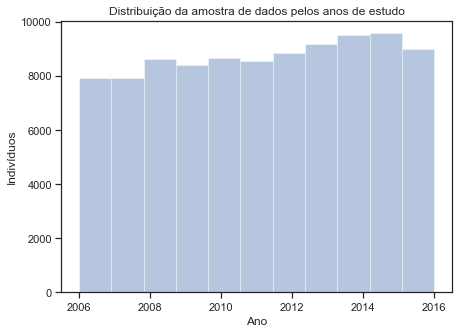

In [7]:
plt.figure(figsize=(7,5))
sns.set(style="ticks", color_codes=True)
a = sns.distplot(df[['ano']], kde=False, bins=11)
a.title.set_text('Distribuição da amostra de dados pelos anos de estudo')
a.set(ylabel='Indivíduos')
a.set(xlabel='Ano')
plt.savefig("img/year_distplot.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Samples_size_per_Year_neonatal'></a>

#### Samples size per Year (neonatal deaths)

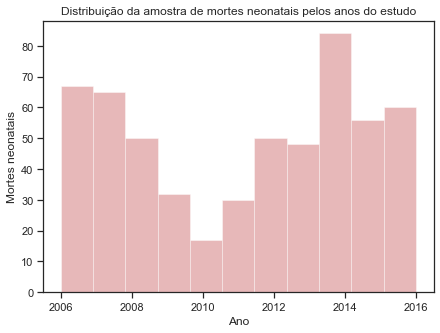

In [8]:
plt.figure(figsize=(7,5))
sns.set(style="ticks", color_codes=True)
a = sns.distplot(dfDeath[['ano']], kde=False, bins=11, color="r")
a.title.set_text('Distribuição da amostra de mortes neonatais pelos anos do estudo')
a.set(ylabel='Mortes neonatais')
a.set(xlabel='Ano')
plt.savefig("img/year_distplot_deaths.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Deaths_distibuiton_per_days'></a>
#### Deaths distibuiton per days

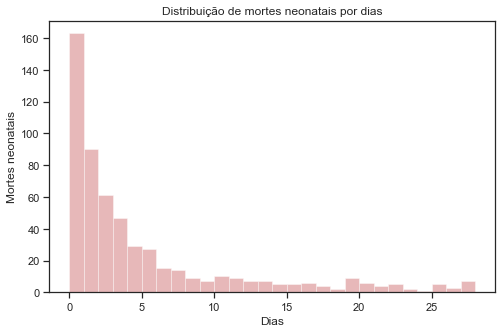

In [9]:
plt.figure(figsize=(8,5))
sns.set(style="ticks", color_codes=True)
a = sns.distplot(dfDeath[['tempo']], kde=False, bins=28, color="r")
a.title.set_text('Distribuição de mortes neonatais por dias')
a.set(ylabel='Mortes neonatais')
a.set(xlabel='Dias')
plt.savefig("img/days_distplot_deaths.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Deaths_distibuiton_per_weeks'></a>
#### Deaths distibuiton per weeks

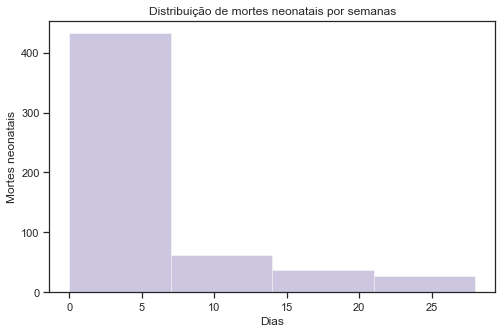

In [10]:
plt.figure(figsize=(8,5))
sns.set(style="ticks", color_codes=True)
a = sns.distplot(dfDeath[['tempo']], kde=False, bins=4, color="m")
a.title.set_text('Distribuição de mortes neonatais por semanas')
a.set(ylabel='Mortes neonatais')
a.set(xlabel='Dias')
plt.savefig("img/weeks_distplot_deaths.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Pairplots1'></a>
#### Pair plots 1: \[gestacoes x idade x consultas_prenatal x status\]
[Home](#top)

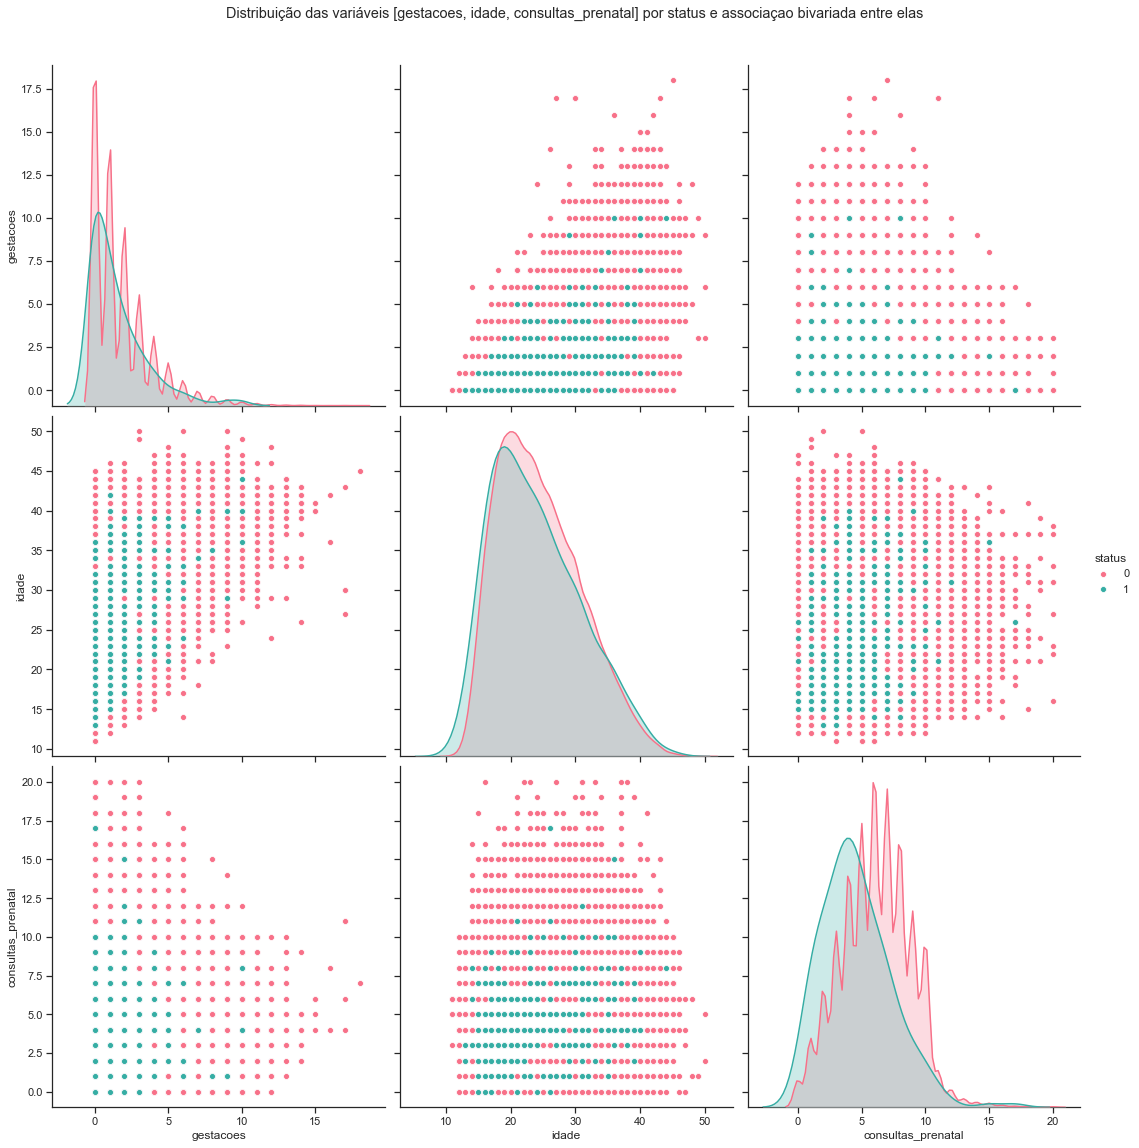

In [11]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[['gestacoes', 'idade','consultas_prenatal','status']], hue='status',
             height=5, aspect=1, palette="husl"
            ).fig.suptitle("Distribuição das variáveis [gestacoes, idade, consultas_prenatal] por status e associaçao bivariada entre elas", y=1.05)
plt.savefig("img/pairplot_status.png", dpi=300, 
            bbox_inches='tight', pad_inches=0.5)

<a id='Pairplots2'></a>
#### Pair plots 2 (Deaths): gestacoes x idade x consultas_prenatal x status
[Home](#top)

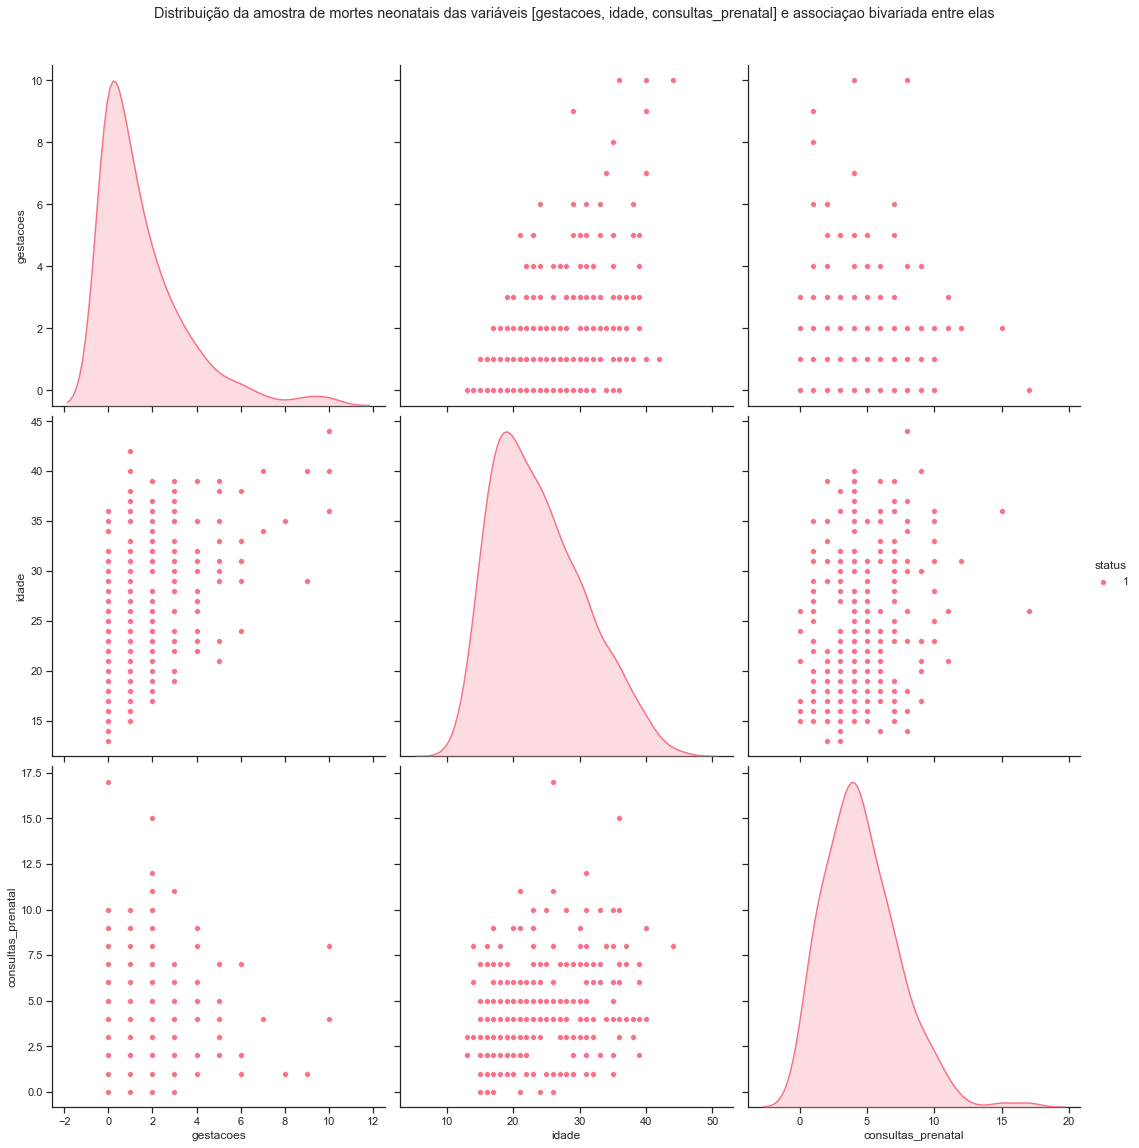

In [12]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(dfDeath[['gestacoes', 'idade','consultas_prenatal','status']], hue='status',
             height = 5, aspect=1, palette="husl"
            ).fig.suptitle("Distribuição da amostra de mortes neonatais das variáveis [gestacoes, idade, consultas_prenatal] e associaçao bivariada entre elas", y=1.05)
plt.savefig("img/pairplot_status_deaths.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Pairplots3'></a>
#### Pair plots 3: \[gestacoes x idade x consultas_prenatal x parto\]
[Home](#top)

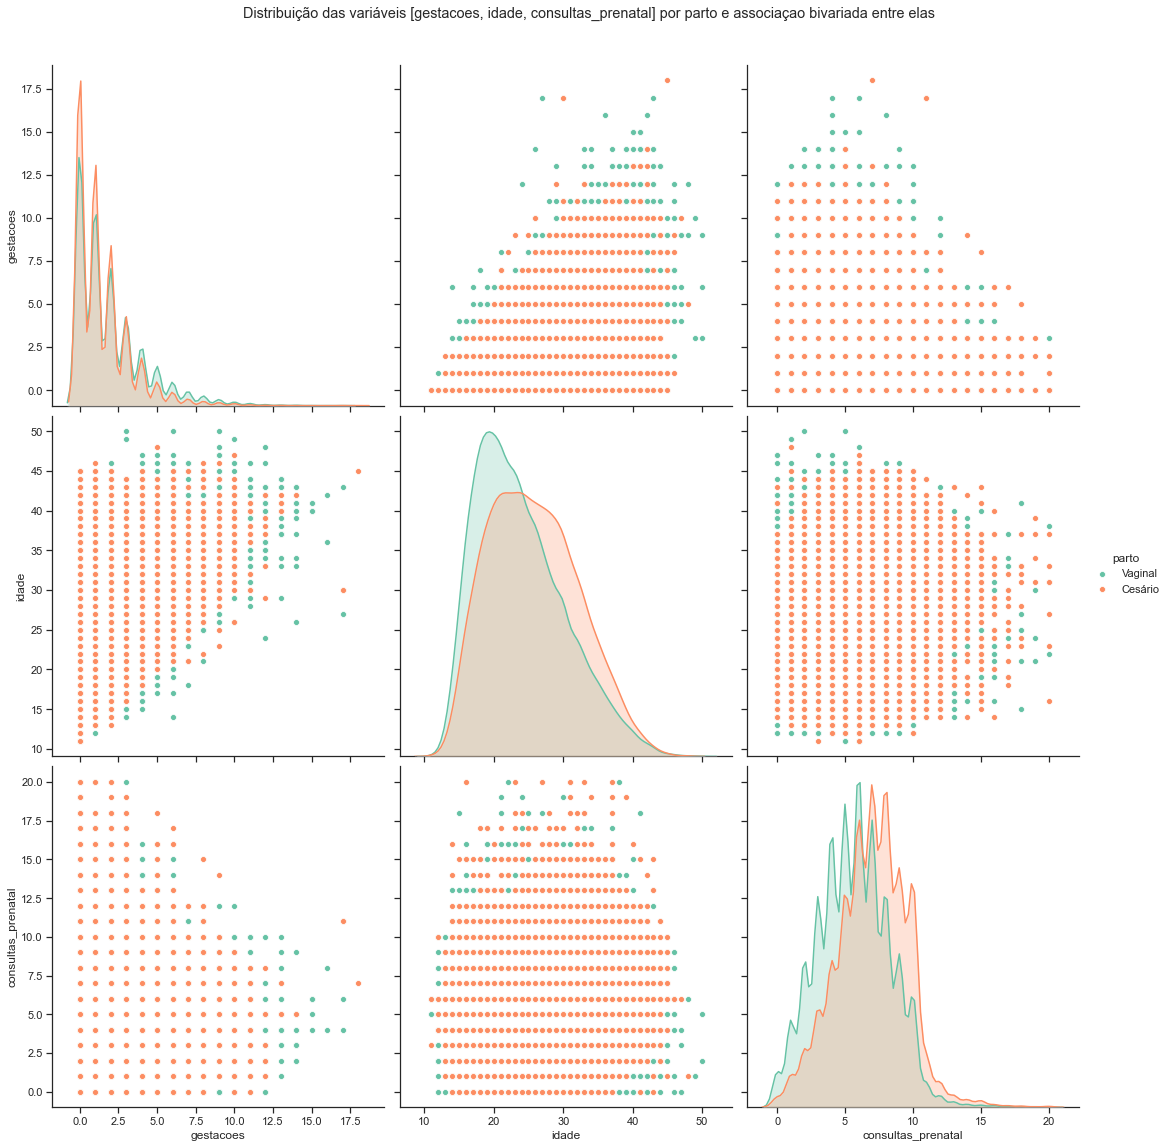

In [13]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[['gestacoes', 'idade','consultas_prenatal','parto']], hue='parto', 
             height = 5, aspect=1, palette="Set2"
            ).fig.suptitle("Distribuição das variáveis [gestacoes, idade, consultas_prenatal] por parto e associaçao bivariada entre elas", y=1.05)
plt.savefig("img/pairplots_parto.png", dpi=300, bbox_inches='tight',pad_inches=0.5)

<a id='Pairplots4'></a>
#### Pair plots 4 (Deaths): \[gestacoes x idade x consultas_prenatal x parto\]
[Home](#top)

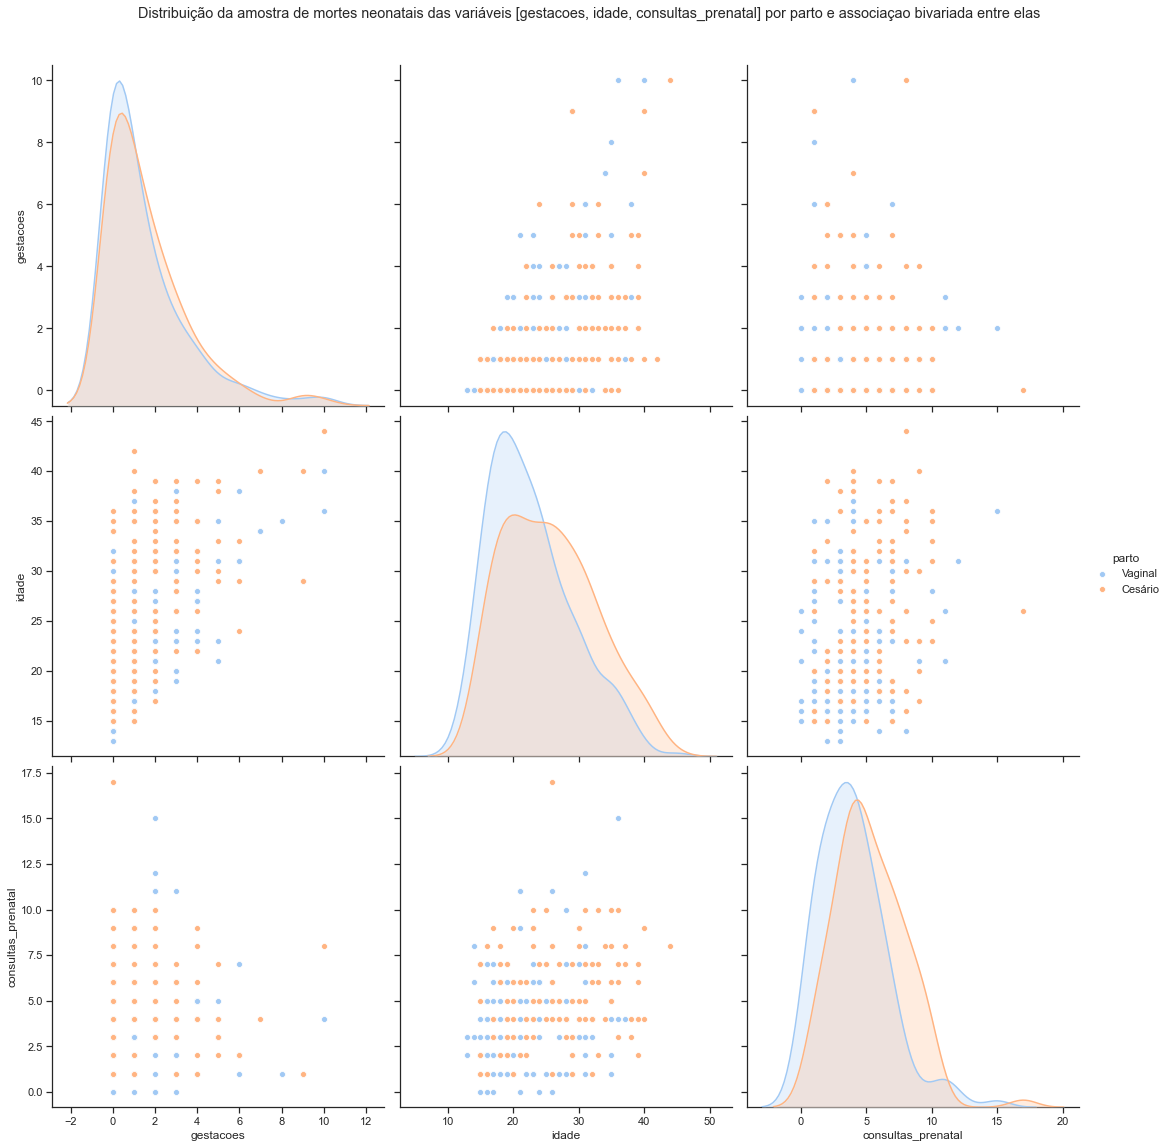

In [14]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(dfDeath[['gestacoes', 'idade','consultas_prenatal','parto']], hue='parto',
             height=5, aspect=1, palette="pastel"
            ).fig.suptitle("Distribuição da amostra de mortes neonatais das variáveis [gestacoes, idade, consultas_prenatal] por parto e associaçao bivariada entre elas", y=1.05)
plt.savefig("img/pairplots_parto_deaths.png", dpi=300,
            bbox_inches='tight', pad_inches=0.5)

<a id='Scatterplot1'></a>
#### Scatter Plots: idade x gestacoes
[Home](#top)

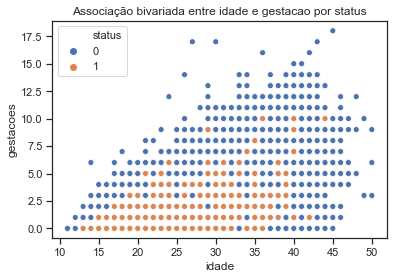

In [15]:
sns.scatterplot(x="idade", y="gestacoes", hue="status",
                data=df).title.set_text('Associação bivariada entre idade e gestacao por status')
plt.savefig("img/scatterplot_idade_gestacao.png", dpi=300)

<a id='Scatterplot2'></a>
#### Scatter Plots: idade x consultas_prenatal
[Home](#top)

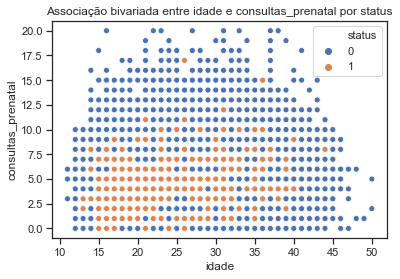

In [16]:
sns.scatterplot(x="idade", y="consultas_prenatal", hue="status", 
                data=df).title.set_text('Associação bivariada entre idade e consultas_prenatal por status')
plt.savefig("img/scatterplot_idade_consultas.png", dpi=300)

#### Quantitativa continuous features quartales
[Home](#top)

<a id='Quartiles1'></a>
##### parto x  (idade, gestacoes, consultas_prenatal, ano)

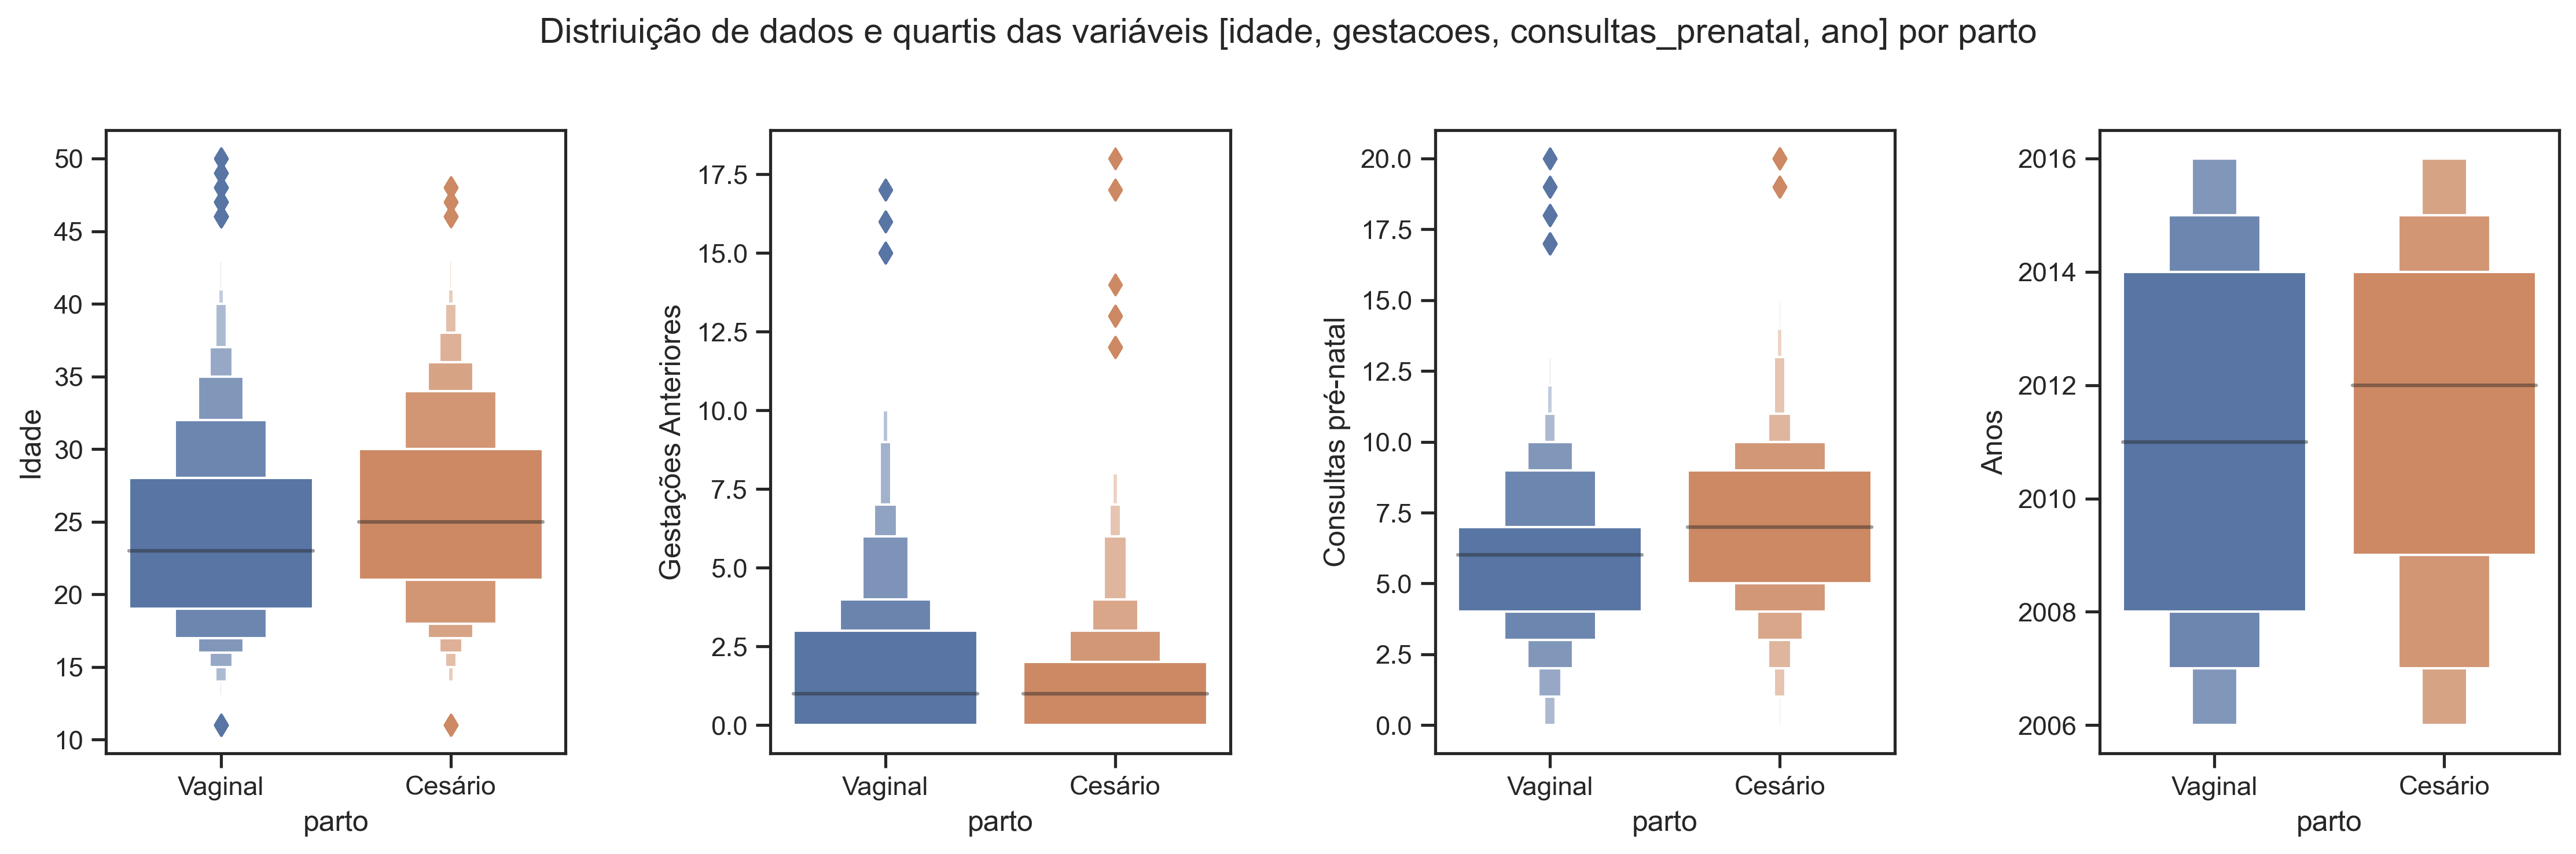

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15,5), dpi=300)

sns.boxenplot(x='parto', y='Idade', 
              data=df.rename(columns={'idade':'Idade'}), ax=axs[0]);
sns.boxenplot(x='parto', y='Gestações Anteriores', 
              data=df.rename(columns={'gestacoes':'Gestações Anteriores'}), ax=axs[1]);
sns.boxenplot(x='parto', y='Consultas pré-natal', 
              data=df.rename(columns={'consultas_prenatal':'Consultas pré-natal'}), ax=axs[2]);
sns.boxenplot(x='parto', y='Anos', 
              data=df.rename(columns={'ano':'Anos'}), ax=axs[3]);

fig.tight_layout(h_pad=3, w_pad=3)
plt.suptitle('Distriuição de dados e quartis das variáveis [idade, gestacoes, consultas_prenatal, ano] por parto')
plt.subplots_adjust(top=0.85)

plt.savefig('img/quantitativa_continuous_features_quartales_parto.png')
plt.show()

<a id='Quartiles2'></a>
##### status x  (idade, gestacoes, consultas_prenatal, ano)

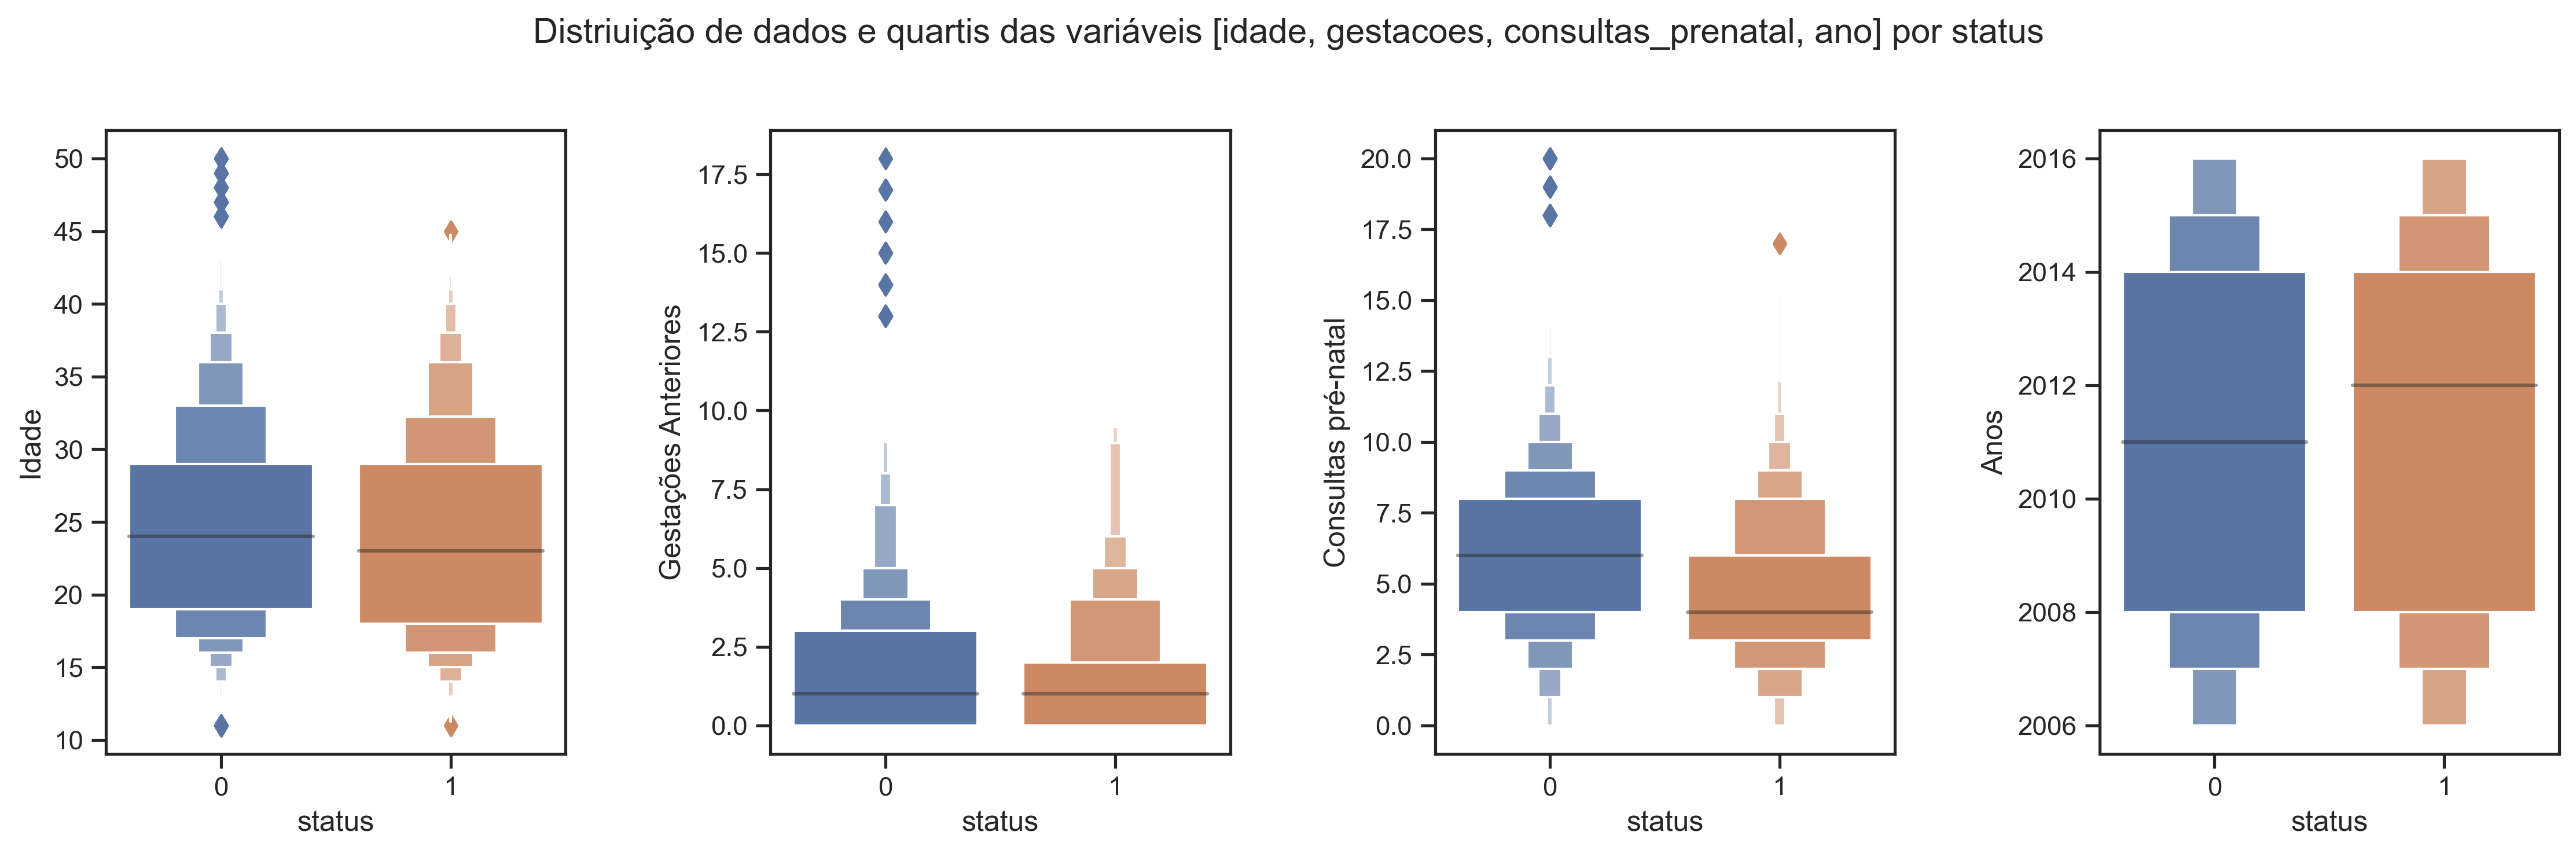

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15,5), dpi=300)

sns.boxenplot(x='status' , y='Idade', data=df.rename(columns={'idade':'Idade'}), ax=axs[0]);
sns.boxenplot(x='status' , y='Gestações Anteriores', data=df.rename(columns={'gestacoes':'Gestações Anteriores'}), ax=axs[1]);
sns.boxenplot(x='status' , y='Consultas pré-natal', data=df.rename(columns={'consultas_prenatal':'Consultas pré-natal'}), ax=axs[2]);
sns.boxenplot(x='status' , y='Anos', data=df.rename(columns={'ano':'Anos'}), ax=axs[3]);

fig.tight_layout(h_pad=3, w_pad=3)
plt.suptitle('Distriuição de dados e quartis das variáveis [idade, gestacoes, consultas_prenatal, ano] por status')

plt.subplots_adjust(top=0.85)

plt.savefig('img/quantitativa_continuous_features_quartales_status.png')
plt.show()

#### Categorical counts
[Home](#top)

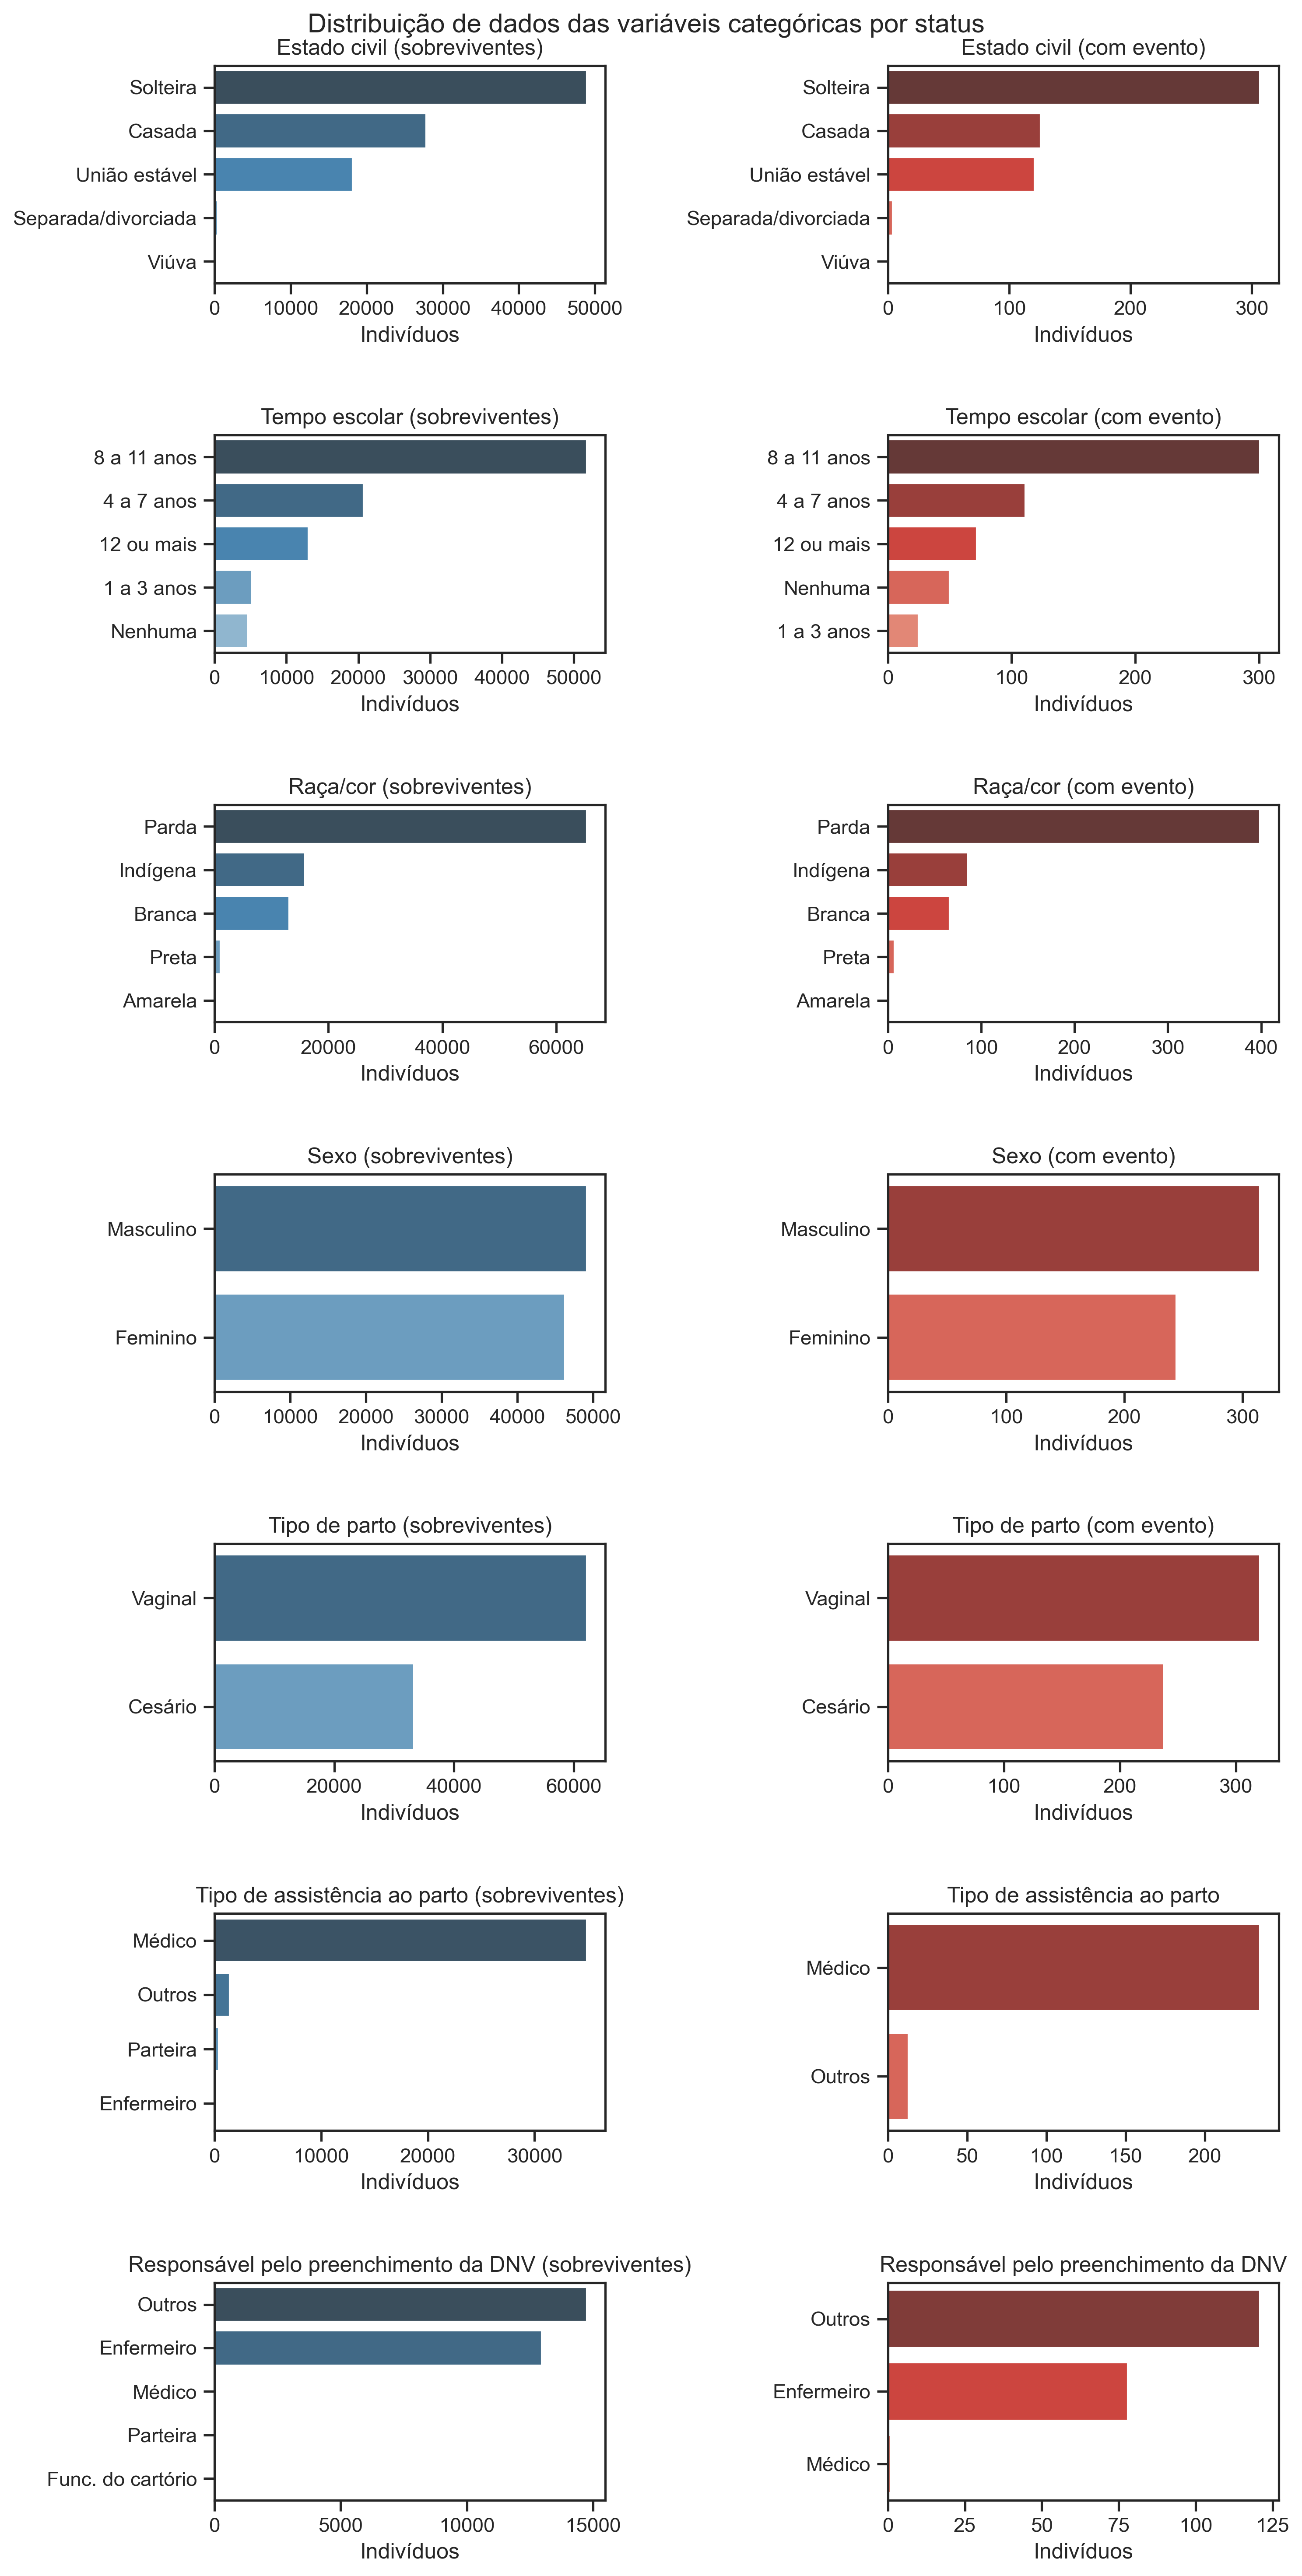

In [19]:
# 
fig, axs = plt.subplots(7, 2, figsize=(10,20), dpi=300)

def add_graph(linha,coluna,p_dfAux,col,p_subtitle0,p_pallete):
    axs[linha,coluna].title.set_text(p_subtitle0)
    sns.countplot(y=col, data=p_dfAux, ax=axs[linha,coluna], palette=p_pallete, order=p_dfAux[col].value_counts().index)
    axs[linha,coluna].set(xlabel='Indivíduos')
    axs[linha,coluna].set(ylabel='')

i = 0
add_graph(i,0,dfAlive,'estado_civil','Estado civil (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'estado_civil','Estado civil (com evento)' , 'Reds_d')
i = i+1
add_graph(i,0,dfAlive,'escolaridade','Tempo escolar (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'escolaridade','Tempo escolar (com evento)' ,'Reds_d' )
i = i+1
add_graph(i,0,dfAlive,'raca_cor','Raça/cor (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'raca_cor','Raça/cor (com evento)' ,'Reds_d' )
i = i+1
add_graph(i,0,dfAlive,'sexo','Sexo (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'sexo','Sexo (com evento)' ,'Reds_d' )
i = i+1
add_graph(i,0,dfAlive,'parto','Tipo de parto (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'parto','Tipo de parto (com evento)' ,'Reds_d' )
i = i+1
add_graph(i,0,dfAlive,'assistencia_nasc','Tipo de assistência ao parto (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'assistencia_nasc','Tipo de assistência ao parto' ,'Reds_d' )
i = i+1
add_graph(i,0,dfAlive,'preenchimento_dnv','Responsável pelo preenchimento da DNV (sobreviventes)' , 'Blues_d')
add_graph(i,1,dfDeath,'preenchimento_dnv','Responsável pelo preenchimento da DNV' ,'Reds_d' )

fig.tight_layout(h_pad=3, w_pad=3)
plt.suptitle('Distribuição de dados das variáveis categóricas por status')
plt.subplots_adjust(top=0.96)

plt.savefig('img/categorical_features_counts.png')

plt.show()

<a id='boxplot1'></a>
#### Boxplot distribuiton: (ano x idade x parto)
[Home](#top)

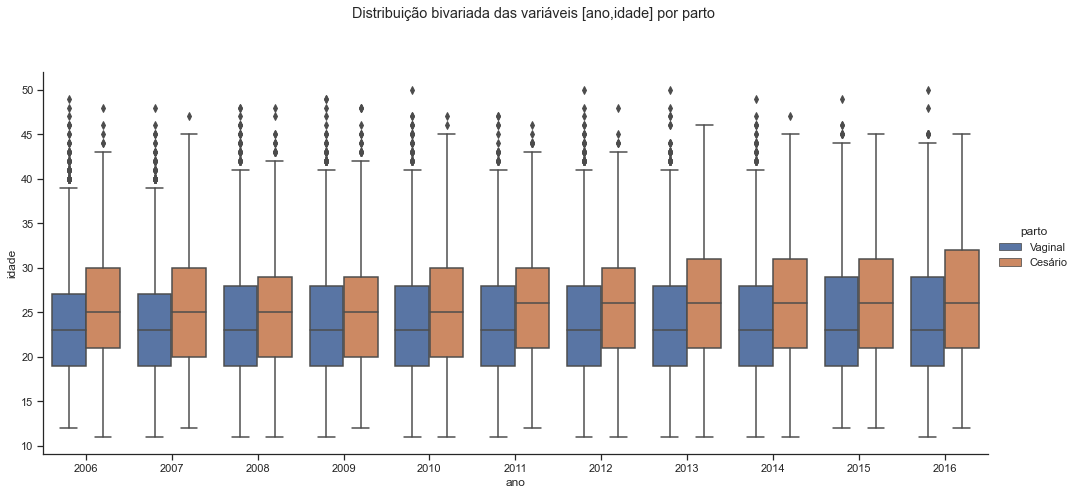

In [20]:
sns.catplot(data=df, x='ano', y='idade', hue='parto', kind='box',
    height=7, aspect=2)

fig.tight_layout(h_pad=3, w_pad=3)
plt.suptitle('Distribuição bivariada das variáveis [ano,idade] por parto')
plt.subplots_adjust(top=0.85)

plt.savefig('img/boxplot_anoXidadeXparto.png')
plt.show()

<a id='boxplot2'></a>
#### Boxplot distribuiton: (escolaridade x idade x parto)

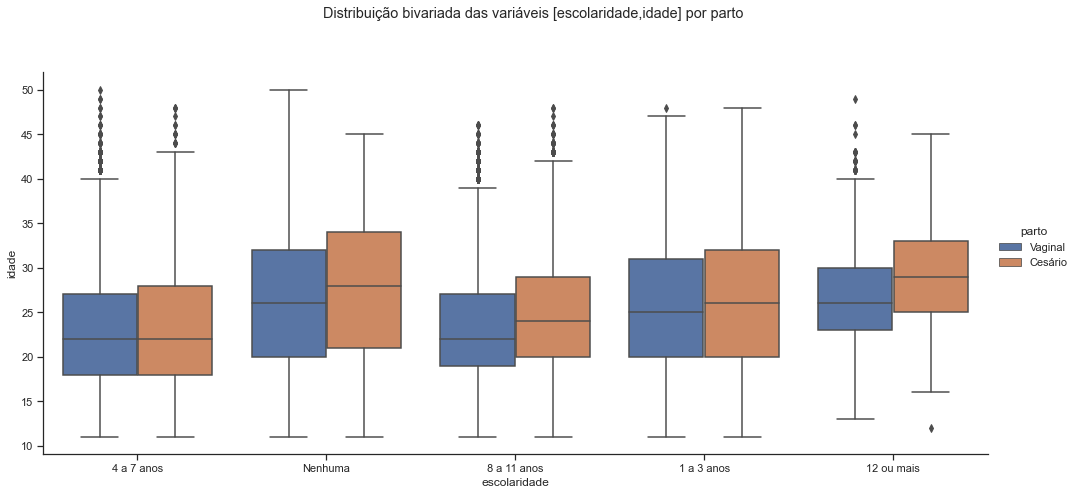

In [21]:
sns.catplot(data=df, x='escolaridade', y='idade', hue='parto', kind='box',
    height=7, aspect=2)

fig.tight_layout(h_pad=3, w_pad=3)
plt.suptitle('Distribuição bivariada das variáveis [escolaridade,idade] por parto')
plt.subplots_adjust(top=0.85)

plt.savefig('img/boxplot_escolaridadeXidadeXparto.png')
plt.show()

<a id='boxplot3'></a>
#### Boxplot distribuiton: (ano x idade x status)

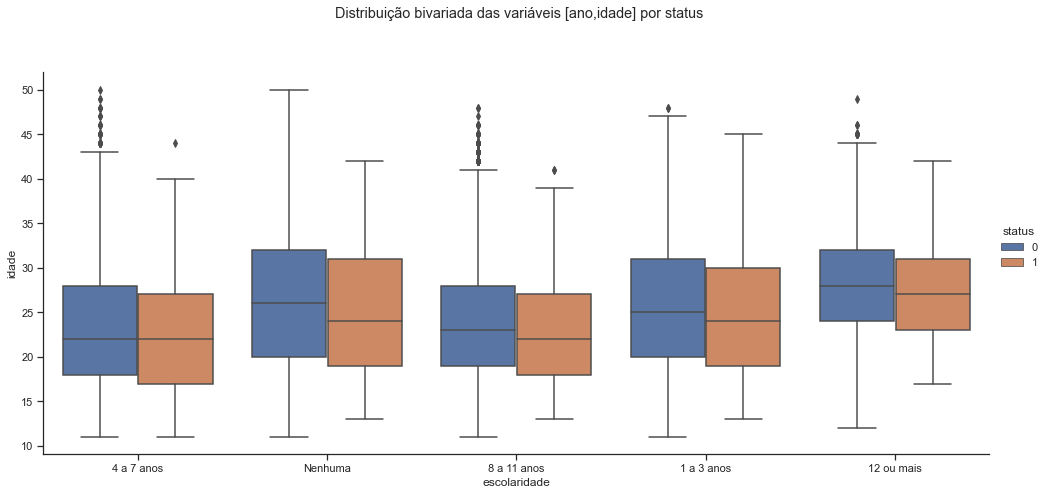

In [22]:
sns.catplot(data=df, x='escolaridade', y='idade', hue='status', kind='box',
    height=7, aspect=2)

fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribuição bivariada das variáveis [ano,idade] por status')

plt.savefig('img/boxplot_escolaridadeXidadeXstatus.png')
plt.show()

<a id='boxplot4'></a>
#### Boxplot distribuiton: (consultas_prenatal x idade x parto)

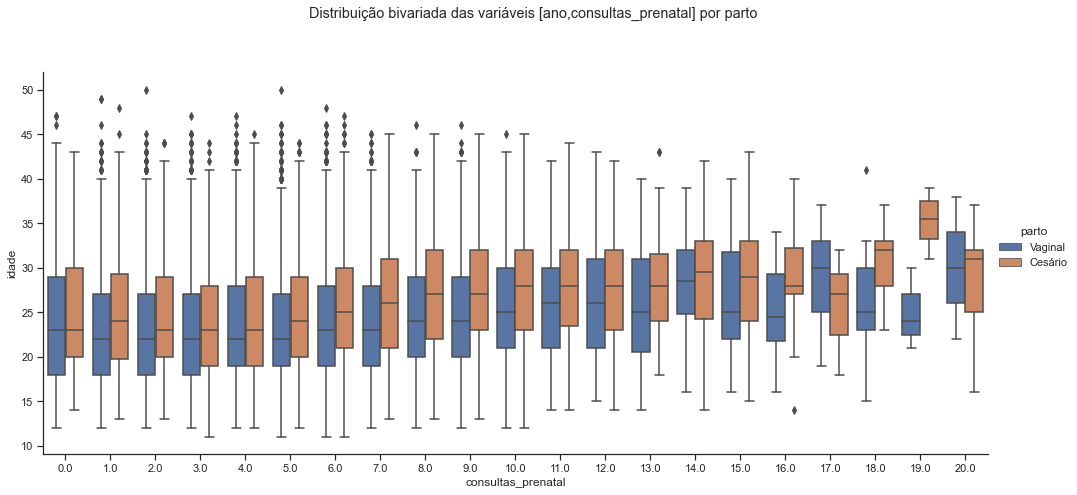

In [23]:
sns.catplot(data=df, x='consultas_prenatal', y='idade', hue='parto', kind='box',
    height=7, aspect=2)

fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribuição bivariada das variáveis [ano,consultas_prenatal] por parto')

plt.savefig('img/boxplot_prenatalXidadeXparto.png')
plt.show()

<a id='boxplot5'></a>
#### Boxplot distribuiton: (consultas_prenatal x idade x status)

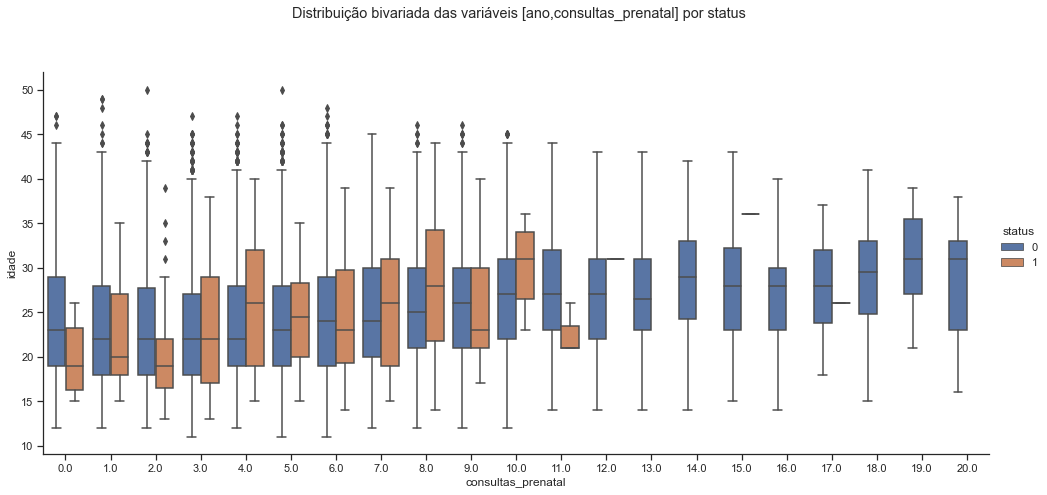

In [24]:
sns.catplot(data=df, x='consultas_prenatal', y='idade', hue='status', kind='box', height=7, aspect=2)
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribuição bivariada das variáveis [ano,consultas_prenatal] por status')
plt.savefig('img/boxplot_prenatalXidadeXstatus.png')
plt.show()

<a id='boxplot6'></a>
#### Boxplot distribuiton: (ano x idade x status)

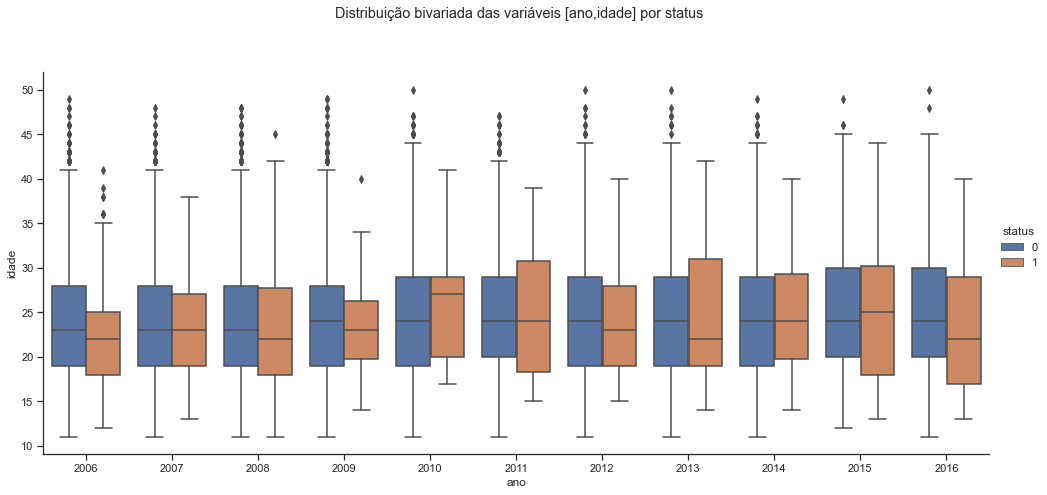

In [25]:
sns.catplot(data=df, x='ano', y='idade', hue='status', kind='box',height=7, aspect=2)
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribuição bivariada das variáveis [ano,idade] por status')
plt.savefig('img/boxplot_anoXidadeXstatus.png')
plt.show()

In [26]:
#kde????
#g = sns.jointplot("idade", "gestacoes", data=dfDeath, kind="kde")
#g = sns.jointplot("idade", "consultas_prenatal", data=dfDeath, kind="kde")
#g = sns.jointplot("idade", "escolaridade", data=dfDeath, kind="kde")
#g = sns.jointplot("idade", "estado_civil", data=dfDeath, kind="kde")
#g = sns.jointplot("ano", "escolaridade", data=df, kind="kde")
#g = sns.jointplot("ano", "estado_civil", data=df, kind="kde")
#g = sns.jointplot("ano", "idade", data=df, kind="kde")
#g = sns.jointplot("ano", "consultas_prenatal", data=df, kind="kde")
#g = sns.jointplot("ano", "raca_cor", data=df, kind="kde")

In [27]:
# Plot the responses for different events and regions
#sns.lineplot(x="idade", y="consultas_prenatal", hue="status", data=df)
#sns.lineplot(x="idade", y="gestacoes", hue="status", data=df)
#sns.lineplot(x="idade", y="escolaridade", hue="status", data=df)

#sns.lineplot(x="ano", y="escolaridade", hue="status", data=df)
#sns.lineplot(x="ano", y="consultas_prenatal", hue="status", data=df)
#sns.lineplot(x="ano", y="gestacoes", hue="status", data=df)
#sns.lineplot(x="ano", y="idade", hue="status", data=df)
#sns.lineplot(x="ano", y="raca_cor", hue="status", data=df)

#Fazer cumulativo
#sns.lineplot(x="ano", y="idade", hue="parto", data=dfDeath)
#sns.lineplot(x="ano", y="escolaridade", hue="parto", data=dfDeath)
#sns.lineplot(x="idade", y="escolaridade", hue="parto", data=dfDeath)
#sns.lineplot(x="idade", y="consultas_prenatal", hue="parto", data=dfDeath)
#sns.lineplot(x="idade", y="gestacoes", hue="parto", data=dfDeath)


In [28]:

#sns.relplot(x="ano", y="idade", hue="status", style="parto", kind="line", data=df);
#sns.relplot(x="ano", y="escolaridade", hue="status", style="parto", kind="line", data=df);
#sns.relplot(x="ano", y="consultas_prenatal", hue="status", style="parto", kind="line", data=df);


<a id='R_prepar'></a>
### Preparing dataframes for R
---------------------------------------------------------------------------------------
[Home](#top)

In [4]:
# Enabling R
%reload_ext rpy2.ipython
#del(df)
#del(dfOri)

/opt/anaconda3/envs/DM017/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [6]:
%%R
library(survival)
dfOri = read.table("tmp/RR.csv", header=T, sep=",")

In [7]:
%%R
# Dataset local copies
df = dfOri

estado_civil_lbl = c("Solteira", "Casada", "Viúva", "Separada/divorciada", "União estável")
escolaridade_lbl = c("Nenhuma", "1 a 3 anos", "4 a 7 anos", "8 a 11 anos", "12 ou mais")
raca_cor_lbl = c("Branca", "Preta", "Amarela", "Parda", "Indígena")
sexo_lbl = c("Masculino", "Feminino")
parto_lbl = c("Vaginal", "Cesário")
assistencia_nasc_lbl = c("Médico","Enfermeira","Parteira","Outros")
preenchimento_dnv_lbl = c("Médico","Enfermeiro","Parteira","Func. do cartório","Outros")

# Addind value labels
df$estado_civil <- factor(df$estado_civil, labels = estado_civil_lbl)
df$escolaridade <- factor(df$escolaridade, labels = escolaridade_lbl)
df$raca_cor <- factor(df$raca_cor, labels = raca_cor_lbl)
df$sexo <- factor(df$sexo, labels = sexo_lbl)
df$parto <- factor(df$parto, labels = parto_lbl)
df$assistencia_nasc <- factor(df$assistencia_nasc, labels = assistencia_nasc_lbl)
df$preenchimento_dnv <- factor(df$preenchimento_dnv, labels = preenchimento_dnv_lbl)

# Create ref dataframes for each class
dfDeath = subset(df, status==1)
dfAlive = subset(df, status==0)

cat('Dimensões do Dataset (linhas x colunas):\n')
cat(dim(df))

cat('\n\nDistribuição entre as classes (0 - sobreviventes X 1 - mortes neonatais):\n')
cat(table(df$status))

Dimensões do Dataset (linhas x colunas):
96074 16

Distribuição entre as classes (0 - sobreviventes X 1 - mortes neonatais):
95515 559

<a id='R_data_desc'></a>
### Datatables descriptions

#### Full dataset

In [32]:
%%R
myVars = c('estado_civil','escolaridade','raca_cor','sexo','parto','assistencia_nasc','preenchimento_dnv')
write.csv(as.matrix(summary(df[myVars])), file="table/summary_R_cat.csv")

write.csv(as.matrix(summary(df)), file="table/summary_R.csv")
as.matrix(summary(df))

       X              ano            ini            fim           tempo      
 Min.   :    0   Min.   :2006   Min.   :   0   Min.   :   4   Min.   : 0.00  
 1st Qu.:24018   1st Qu.:2008   1st Qu.:1078   1st Qu.:1107   1st Qu.:29.00  
 Median :48036   Median :2011   Median :2110   Median :2139   Median :29.00  
 Mean   :48036   Mean   :2011   Mean   :2070   Mean   :2099   Mean   :28.86  
 3rd Qu.:72055   3rd Qu.:2014   3rd Qu.:3081   3rd Qu.:3110   3rd Qu.:29.00  
 Max.   :96073   Max.   :2016   Max.   :3986   Max.   :4015   Max.   :29.00  
                                                                             
     status             idade                    estado_civil  
 Min.   :0.000000   Min.   :11.00   Solteira           :49237  
 1st Qu.:0.000000   1st Qu.:19.00   Casada             :27964  
 Median :0.000000   Median :24.00   Viúva              :  115  
 Mean   :0.005818   Mean   :24.53   Separada/divorciada:  441  
 3rd Qu.:0.000000   3rd Qu.:29.00   União estável      :

#### Death samples

In [33]:
%%R
myVars = c('estado_civil','escolaridade','raca_cor','sexo','parto','assistencia_nasc','preenchimento_dnv')
write.csv(as.matrix(summary(dfDeath[myVars])), file="table/summary_R_cat_death.csv")

write.csv(as.matrix(summary(dfDeath)), file="table/summary_R_death.csv")
as.matrix(summary(dfDeath))

       X              ano            ini            fim           tempo       
 Min.   :95515   Min.   :2006   Min.   :   0   Min.   :   4   Min.   : 0.000  
 1st Qu.:95654   1st Qu.:2008   1st Qu.: 766   1st Qu.: 768   1st Qu.: 0.000  
 Median :95794   Median :2012   Median :2337   Median :2342   Median : 2.000  
 Mean   :95794   Mean   :2011   Mean   :2066   Mean   :2071   Mean   : 4.648  
 3rd Qu.:95934   3rd Qu.:2014   3rd Qu.:3192   3rd Qu.:3194   3rd Qu.: 6.000  
 Max.   :96073   Max.   :2016   Max.   :3978   Max.   :3992   Max.   :28.000  
                                                                              
     status      idade                    estado_civil      escolaridade
 Min.   :1   Min.   :11.00   Solteira           :307   Nenhuma    : 50  
 1st Qu.:1   1st Qu.:18.00   Casada             :126   1 a 3 anos : 25  
 Median :1   Median :23.00   Viúva              :  1   4 a 7 anos :111  
 Mean   :1   Mean   :23.97   Separada/divorciada:  4   8 a 11 anos:301  
 3r

<a id='surv_classic'></a>
### Tempo de Sobrevivência no formato clássico

In [34]:
%%R
sink(file("table/survivor_time_classic.csv", open="wt"),  split=TRUE)
print(Surv(dfDeath$tempo,dfDeath$status))
sink()

  [1]  4  0  0 12  0  2  2  0  1  7  0  0 21  5  1  1  0  1  1  0 10  0  0 15  1
 [26]  7 16  2 11  1  5  1  5 17  0  2 10  0 23  3  0  0  1  0  6  0  0  0  0  2
 [51]  6  8 22  3 14  3  3  1 18  0 12  3  1 11  4 28  8  0  0  1  2  2  0  0  1
 [76]  1  2  3  6  2  2  1  1 11  0  0  0  0 28  0  3  0  1  1  0  9 22  0  0  0
[101]  1  0 17  0  0  0 12 13  3  0  0  0  0  1  5 13  0  5  2  5  0  0  0 18  0
[126] 25 15  1  1  1  3  3  0  0  0  0  3  4  1  0  4  0  0  1  1  0 12 12  0 20
[151]  4  1  2  5  0  0  0  1  0  8  6 25  4  2  6  0  0  1  1  0  3  2  0  1  1
[176]  0  1  0  0  0 10  0 13  8  1  0  0 15  1  3  7 11  1  0  1  6  4 20  1  5
[201]  0  7 10 11  3 21  9 17  0  5  8  2 20  7  3 19  3  1 27  1  0  1 20 27 26
[226]  0  5  0  3  0  0  2  2  2  0  1  3  2  0 19  0  1  0  0  0  1  2 13  4  2
[251]  1  0  0  1  0  1  0  7  3  2 21  2  2 11  3  4  2  1  3  0  0  1 21  0 10
[276] 28  4 26  0  2  0  6  0  3  5  3  3  0  4  0  0  2  2  0  4 19  3  3  1  2
[301]  2  2  3  1  2  5  5  

<a id='surv_count'></a>
### Tempo de Sobrevivência no formato de processo de contagem
[Home](#top)

#### Sample os Survivors (100 rows)

In [5]:
%%R
sink(file("table/survivor_time_count_process.csv", open="wt"),  split=TRUE)
mysample <- dfAlive[sample(1:nrow(dfAlive), 100, replace=FALSE),]
print(Surv(mysample$ini, mysample$fim, mysample$status))
sink()


Error in withVisible({ : object 'dfAlive' not found


/opt/anaconda3/envs/DM017/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in withVisible({ : object 'dfAlive' not found

  warnings.warn(x, RRuntimeWarning)


#### Neonatal deaths

In [9]:
%%R
sink(file("table/survivor_time_count_process_deaths.csv", open="wt"),  split=TRUE)
print(Surv(dfDeath$ini, dfDeath$fim, dfDeath$status))
sink()

  [1] (   0,   4] (  NA,   4] (  NA,   9] (  13,  25] (  NA,  15] (  36,  38]
  [7] (  44,  46] (  NA,  48] (  54,  55] (  83,  90] (  NA,  90] (  NA, 114]
 [13] ( 115, 136] ( 123, 128] ( 132, 133] ( 137, 138] (  NA, 141] ( 146, 147]
 [19] ( 148, 149] (  NA, 155] ( 160, 170] (  NA, 160] (  NA, 161] ( 181, 196]
 [25] ( 184, 185] ( 203, 210] ( 208, 224] ( 214, 216] ( 215, 226] ( 220, 221]
 [31] ( 222, 227] ( 236, 237] ( 237, 242] ( 239, 256] (  NA, 241] ( 244, 246]
 [37] ( 246, 256] (  NA, 260] ( 263, 286] ( 272, 275] (  NA, 273] (  NA, 274]
 [43] ( 284, 285] (  NA, 289] ( 304, 310] (  NA, 314] (  NA, 314] (  NA, 319]
 [49] (  NA, 321] ( 326, 328] ( 332, 338] ( 334, 342] ( 337, 359] ( 337, 340]
 [55] ( 337, 351] ( 340, 343] ( 340, 343] ( 343, 344] ( 347, 365] (  NA, 348]
 [61] ( 348, 360] ( 354, 357] ( 354, 355] ( 357, 368] ( 359, 363] ( 360, 388]
 [67] ( 362, 370] (  NA, 365] (  NA, 365] ( 365, 366] ( 367, 369] ( 377, 379]
 [73] (  NA, 381] (  NA, 384] ( 388, 389] ( 394, 395] ( 404, 406

In [37]:
%%R
#sink(file("table/....csv", open="wt"),  split=TRUE)
#sink

cat('\nestado_civil x scolaridade x status')
t = table(df$estado_civil,df$escolaridade,df$status)
print(t)
cat("-----------------------------------------------")

cat('\nraca_cor x escolaridade x status')
t = table(df$raca_cor,df$escolaridade,df$status)
print(t)
cat("-----------------------------------------------")

cat('\nparto x preenchimento_dnv x status')
t = table(df$parto,df$preenchimento_dnv,df$status)
print(t)
cat("-----------------------------------------------")

cat('\nparto x gestacoes')
t = table(df$parto,df$gestacoes,df$status)
print(t)
cat("-----------------------------------------------")

cat('\nconsultas_prenatal x assistencia_nasc')
t = table(df$consultas_prenatal,df$assistencia_nasc,df$status)
print(t)
cat("-----------------------------------------------")

cat('\nassistencia_nasc x preenchimento_dnv x status')
t = table(df$assistencia_nasc,df$preenchimento_dnv,df$status)
print(t)


estado_civil x scolaridade x status, ,  = 0

                     
                      Nenhuma 1 a 3 anos 4 a 7 anos 8 a 11 anos 12 ou mais
  Solteira               1140       3095      12781       27492       4422
  Casada                 2866       1424       4061       13209       6278
  Viúva                    10         10         32          54          8
  Separada/divorciada       2         20         47         219        149
  União estável           650        685       3824       10821       2216

, ,  = 1

                     
                      Nenhuma 1 a 3 anos 4 a 7 anos 8 a 11 anos 12 ou mais
  Solteira                 11         18         79         166         33
  Casada                   29          5         15          51         26
  Viúva                     1          0          0           0          0
  Separada/divorciada       1          0          0           2          1
  União estável             8          2         17          82         12

In [6]:
#! jupyter nbconvert --to html --no-input TrabalhoFinal_01_Analise_Exploratoria.ipynb

[NbConvertApp] Converting notebook TrabalhoFinal_01_Analise_Exploratoria.ipynb to html
[NbConvertApp] Writing 2868343 bytes to TrabalhoFinal_01_Analise_Exploratoria.html


In [38]:
%%R
#boxplot(df$idade ~ df$status, main = "idade", ylab = "idade", xlab = "status")
#boxplot(df$consultas_prenatal ~ df$status, main = "consultas_prenatal", ylab = "consultas_prenatal", xlab = "status")
#boxplot(df$gestacoes ~ df$status, main = "gestacoes", ylab = "gestacoes", xlab = "status")
#boxplot(df$ano ~ df$status, main = "ano", ylab = "ano", xlab = "status")


#hist(df$idade, breaks=60, main = "Idade", ylab = "Freqüência", xlab = "idade")
#hist(dfDeath$idade, breaks=60, main = "Idade (Eventos)", ylab = "Freqüência", xlab = "idade")

#hist(dfDeath$tempo, breaks=28, main = "Tempo Sobrevida", ylab = "Freqüência", xlab = "dias")
#hist(dfDeath$tempo, breaks=7, main = "Tempo Sobrevida (Agrupado por faixa 5 dias)", ylab = "Freqüência", xlab = "dias")

#hist(df$ano, breaks=c(2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017), main = "Ano", ylab = "Freqüência", xlab = "ano")

NULL
